In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import os
import sys

import fitsio
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
import healpy as hp
from healpy.newvisufunc import projview
import pymaster as nmt

#sys.path.insert(0, '/home/aew492/lss-dipoles')
sys.path.insert(0, '/home/investigator/code/lss-dipoles')
#sys.path.insert(0, '..')
import tools
from qso_sample import QSOSample
import dipole
import ellisbaldwin
import multipoles
from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

In [3]:
import matplotlib
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 16

matplotlib.rc('text', usetex=True)

In [4]:
basedir = '../../quasar_data_abby/catalogs'

In [5]:
color_quaia = 'mediumvioletred'
color_catwise = 'teal'
lw = 2
lw_grid = 0.5

### functions

In [6]:
def C_1(dipole_amplitude):  # from the new Abghari et al. (including Douglas Scott), eq. 3.3
    # return dipole_amplitude**2 / 3
    return 4 * np.pi / 9 * dipole_amplitude**2

def D(C_1):
    return np.sqrt(C_1) * 9 / (4 * np.pi)

In [7]:
# define function for jackknife: output needs to be just the Cells, to compute the uncertainty
def Cells_for_jk(overdensity_map, Wmask, max_ell, selfunc=None):
    ells, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map, Wmask, max_ell, selfunc=selfunc)
    return Cells

### load samples and construct overdensity maps

In [8]:
# some key variables !!

# ABBY
# catdir = '/scratch/aew492/quasars/catalogs'
# selfuncdir_quaia = os.path.join(catdir, 'quaia/selfuncs')
# selfuncdir_catwise = os.path.join(catdir, 'catwise_agns/selfuncs')

# KSF
catdir =  '../../quasar_data_abby/catalogs'
selfuncdir_quaia = '../../gaia-quasars-lss/data/maps/'
selfuncdir_catwise = '../../gaia-quasars-lss/data/maps/'

mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')
Wmask = 0.1  # fiducial regularization
max_ell = 8  # max ell to fit

#### CatWISE

In [9]:
# instantiate dipole object:
d_catwise = QSOSample(initial_catfn=os.path.join(catdir, 'catwise_agns/catwise_agns_master.fits'),
              mask_fn=mask_fn,
              mag='W1', maglim=16.4,
              #basedir=basedir,
              blim=30)
d_catwise.cut_galactic_plane_hpx()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_catwise = ellisbaldwin.compute_expected_dipole_wise(d_catwise.table, 
                                                                    maglimit=d_catwise.maglim,
                                                            min_w1=16., max_w1=16.5)  # reasonable min and max around the magnitude limit
d_catwise.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/catwise_agns/catwise_agns_master.fits
8532854 sources in initial catalog.
cut |b| <= 30 based on healpix mask -> 4481299 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.748
	effective alpha = 1.270
	expected dipole amplitude = 0.0074
cut W1 > 16.4 -> 1400868 sources left.


In [10]:
# at the healpix level:

# load selection function
selfunc_catwise = d_catwise.get_selfunc(os.path.join(selfuncdir_catwise,
                                            f'selection_function_NSIDE{d_catwise.NSIDE}_catwise_pluszodis.fits'))

# construct overdensity map with no selection function
overdensity_map_catwise = d_catwise.construct_overdensity_map(selfunc=None)

# and with the selection function
overdensity_map_sf_catwise = d_catwise.construct_overdensity_map(selfunc=selfunc_catwise)

constructing overdensity map
selection function not provided; assuming completeness = 1 in every pixel
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5
constructing overdensity map


In [109]:
# for CatWISE, we also want to correct for a density trend in ecliptic latitude, to match Secrest:
# get the ecliptic latitudes of each healpixel
lon, lat = hp.pix2ang(d_catwise.NSIDE, np.arange(hp.nside2npix(d_catwise.NSIDE)), lonlat=True)
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

# construct the masked datamap
masked_datamap = d_catwise.construct_masked_datamap(selfunc=None, return_map=True)

# fit a line: density vs elat
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap)
p = np.polyfit(np.abs(elat)[idx], masked_datamap[idx], deg=1)
print(p)
# correct the densities and fit to the corrected densities
map_elatcorr = masked_datamap - np.polyval(p, np.abs(elat.value)) + p[1]
p_corr = np.polyfit(np.abs(elat)[idx], map_elatcorr[idx], deg=1) # in case we want to check the corrected trend
# then the overdensity map is
overdensity_map_elat_catwise = map_elatcorr / np.nanmean(map_elatcorr) - 1

selection function not provided; assuming completeness = 1 in every pixel
[-4.14916266e-02  5.77477631e+01]


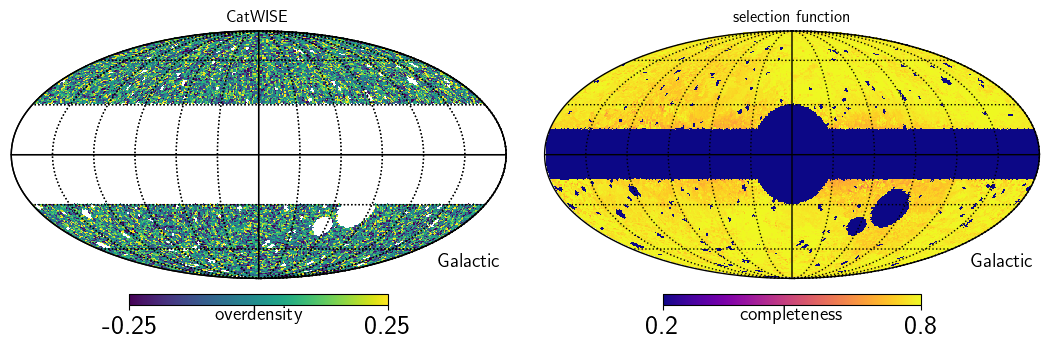

In [95]:
# plot
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_sf_catwise, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'CatWISE')
hp.graticule()
hp.mollview(selfunc_catwise, coord=['C','G'], min=0.2, max=0.8, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()

In [110]:
vals_elatcorr = np.polyval(p, np.abs(elat.value)) + p[1]

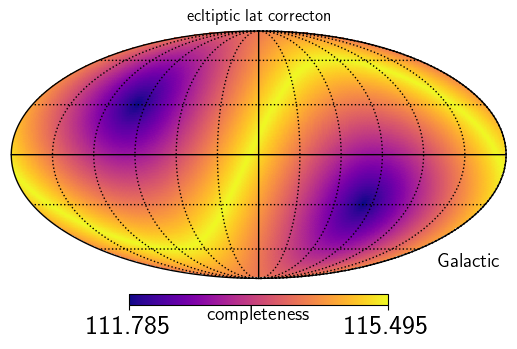

In [112]:
fig = plt.figure(figsize=(16,3))
hp.mollview(vals_elatcorr, coord=['C','G'], 
            #min=30, max=100, 
            badcolor='w', fig=fig, sub=(1,3,1), cmap='plasma',
            unit='completeness', title=f'ecltiptic lat correcton')
hp.graticule()

#### Quaia

In [12]:
# instantiate dipole object:
d_quaia = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
              mask_fn=mask_fn,
              mag='g', maglim=20.,
              blim=30)
d_quaia.cut_galactic_plane_hpx()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_quaia = ellisbaldwin.compute_expected_dipole_gaia(d_quaia.table, maglimit=d_quaia.maglim,
                                                            min_g=19.5, max_g=20.5)  # reasonable min and max around the magnitude limit
d_quaia.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 30 based on healpix mask -> 917917 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.309
	effective alpha = 0.713
	expected dipole amplitude = 0.0052
cut G > 20.0 -> 530559 sources left.


In [13]:
# at the healpix level:

# load selection function
selfunc_quaia = d_quaia.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d_quaia.NSIDE}_G{d_quaia.maglim}.fits'))
# overdensity map, corrected by selection function
min_completeness = 0.5
#min_completeness = 0
overdensity_map_sf_quaia = d_quaia.construct_overdensity_map(selfunc=selfunc_quaia,
                                                            min_completeness=min_completeness #default 0.5
                                                            )

# overdensity map, NOT corrected by selection function
overdensity_map_quaia = d_quaia.construct_overdensity_map(selfunc=None)

constructing overdensity map
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5
constructing overdensity map
selection function not provided; assuming completeness = 1 in every pixel


In [14]:
# oy why are these note exactly the same... (for min_completeness=0.0; fine for 0.5!)
np.sum(d_quaia.mask & (selfunc_quaia > min_completeness)), np.sum(d_quaia.mask)

(22165, 22165)

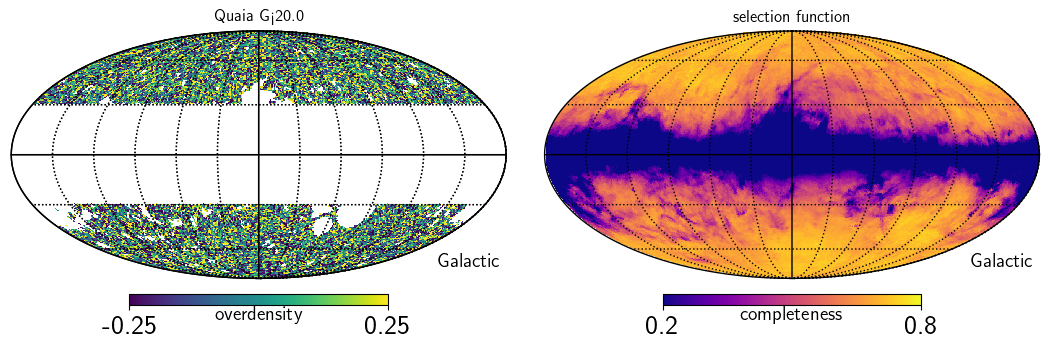

In [15]:
# plot
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_sf_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d_quaia.maglim}')
hp.graticule()
hp.mollview(selfunc_quaia, coord=['C','G'], min=0.2, max=0.8, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()

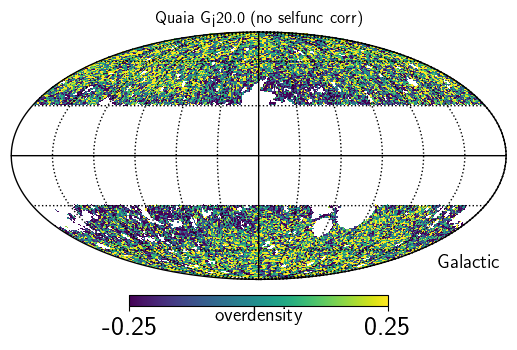

In [16]:
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d_quaia.maglim} (no selfunc corr)')
hp.graticule()

# C_ells direct

In [17]:
# Quaia
ells, Cells_quaia = multipoles.compute_Cells_in_overdensity_map_Wmask(overdensity_map_sf_quaia,
                                                                      Wmask=Wmask, 
                                                                      max_ell=max_ell, selfunc=selfunc_quaia)

In [18]:
save_dir = '../../quasar_data_abby/jackknife'
Cells_quaia_std = np.load(os.path.join(save_dir, f'jk_Cells_std_quaia_sfcorr_ellmax{max_ell}.npy'),
                            allow_pickle=True).item()['Cells_std']

In [19]:
noise_dir = '../../quasar_data_abby/noise_Cells'
res_quaia = np.load(f'{noise_dir}/quaia/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
noise_quaia_Cell = res_quaia['Cells_fullsky'][0]

In [20]:
expected_C1_quaia = C_1(expected_dipamp_quaia)

# NaMaster

Following Alonso+2023 approach, https://github.com/damonge/quaia-cosmo-s8/blob/main/notebooks/CellCalculator.ipynb !

Define bins etc

In [21]:
# Bins
#b = nmt.NmtBin(d_quaia.NSIDE, nlb=30)
l_max = max_ell
ells_nmt = np.arange(1, l_max+1)
bpws = np.arange(len(ells_nmt))
weights = np.ones(len(ells_nmt))/len(ells_nmt)
b = nmt.NmtBin(d_quaia.NSIDE, ells=ells_nmt, bpws=bpws, weights=weights)
#b = nmt.NmtBin(d_quaia.NSIDE, nlb=1, lmax=3)

leff = b.get_effective_ells()
print(leff)

[1. 2. 3. 4. 5. 6. 7. 8.]


In [22]:
map_quaia = overdensity_map_sf_quaia.copy()
map_quaia[np.isnan(map_quaia)] = 0

To compute nl_coupled, we need the mean, so we need to go back to the number counts datamap::

In [23]:
NPIX = hp.nside2npix(d_quaia.NSIDE)

# mask_sf is the selection function with the binary mask masked out; d_quaia.mask is the binary mask
mask_sf = selfunc_quaia.copy()
mask_sf[~d_quaia.mask] = 0.0

In [24]:
# Abby computed the overdensity map with the mean like this
nmean_meanmethodAbby = np.sum(d_quaia.datamap[d_quaia.mask]/(mask_sf[d_quaia.mask]))/np.sum(d_quaia.mask)
nmean_srad_meanmethodAbby = nmean_meanmethodAbby * NPIX / (4*np.pi)
nl_coupled_meanmethodAbby = np.mean(mask_sf) / nmean_srad_meanmethodAbby * np.ones((1, 3*d_quaia.NSIDE))

In [25]:
# David does it like this; let's compare
nmean_meanmethodDavid = np.sum(d_quaia.datamap*d_quaia.mask)/np.sum(selfunc_quaia*d_quaia.mask)
nmean_srad_meanmethodDavid = nmean_meanmethodDavid * NPIX / (4*np.pi)
nl_coupled_meanmethodDavid = np.mean(mask_sf) / nmean_srad_meanmethodDavid * np.ones((1, 3*d_quaia.NSIDE))

In [26]:
print("David mean:", nmean_meanmethodDavid, "Abby mean:", nmean_meanmethodAbby)

David mean: 33.63223392439692 Abby mean: 33.63190694514303


They agree to the 0.001's place!

Let's also try making the overdensity map the Alonso way

In [27]:
delta_david = np.zeros(NPIX)
delta_david[d_quaia.mask] = d_quaia.datamap[d_quaia.mask]/(nmean_meanmethodDavid*mask_sf[d_quaia.mask])-1

In [28]:
np.mean(map_quaia[d_quaia.mask]), np.mean(delta_david[d_quaia.mask])

(-1.053071458142084e-16, -9.722198490382863e-06)

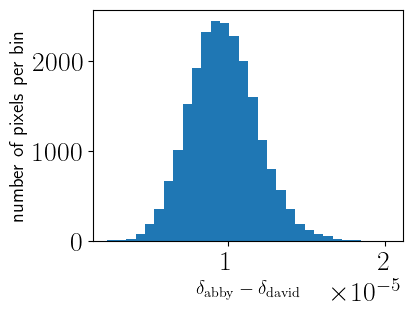

In [29]:
plt.figure(figsize=(4,3))
plt.hist((map_quaia - delta_david)[d_quaia.mask], bins=30)
plt.xlabel(r'$\delta_\mathrm{abby} - \delta_\mathrm{david}$', fontsize=14)
plt.ylabel('number of pixels per bin', fontsize=14)
plt.show()

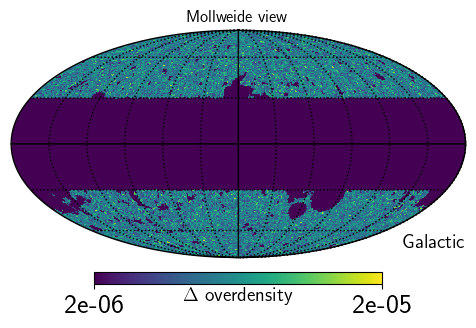

In [30]:
fig = plt.figure(figsize=(6,3))
hp.mollview(map_quaia - delta_david, coord=['C','G'], min=2e-6, max=2e-5, badcolor='w', fig=fig, #sub=(1,3,1),
            unit=r'$\Delta$ overdensity')
hp.graticule()
plt.show()

The abby way leaves mean exactly zero (to numerical precision), while David way leaves a small mean but is more robust to low-completeness pixels. They have very small differences, along with the mean offset.

Now make the Namaster fields:

In [31]:
f_quaia = nmt.NmtField(mask_sf, [map_quaia], n_iter=0)

In [32]:
f_quaia_david = nmt.NmtField(mask_sf, [delta_david], n_iter=0)

Set up C_ell calculator and compute:

In [33]:
# Calculator
def get_cl(f1, f2, b, pnl=None):
    pcl = nmt.compute_coupled_cell(f1, f2)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f1, f2, b)
    cl = w.decouple_cell(pcl)
    if pnl is not None:
        nl = w.decouple_cell(pnl)
        cl -= nl
    else:
        nl = np.zeros_like(cl)
    wins = w.get_bandpower_windows()
    return cl, nl, w, wins.squeeze()

Make sure to be consistent with the mean methods!

In [34]:
cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, b, 
                        pnl=nl_coupled_meanmethodAbby)
print(cl)

[[ 2.03353959e-04 -1.00668542e-06 -2.98651439e-05 -4.72641429e-06
   4.90964174e-05  2.50866902e-05  2.37162147e-05  1.32582190e-05]]


In [35]:
cl_david, nl_david, w_david, Bbl_david = get_cl(f_quaia_david, f_quaia_david, b, 
                                                pnl=nl_coupled_meanmethodDavid)
print(cl_david)

[[ 2.03323890e-04 -1.10604188e-06 -2.98631463e-05 -4.68296600e-06
   4.90963804e-05  2.50781243e-05  2.37132187e-05  1.32635348e-05]]


Covariance computation:

In [36]:
def get_cov(f1, f2, f3, f4, w12, w34):
    fs = [f1, f2, f3, f4]
    ms = [f.get_mask() for f in fs]
    # Compute all pseudo-Cls
    cls = np.array([[nmt.compute_coupled_cell(fs[i], fs[j])/np.mean(ms[i]*ms[j])
                     for i in range(4)] for j in range(4)])
    cw = nmt.NmtCovarianceWorkspace()
    cw.compute_coupling_coefficients(f1, f2, f3, f4)
    cv = nmt.gaussian_covariance(cw, 0, 0, 0, 0, cls[0, 2], cls[0, 3], cls[1, 2], cls[1, 3], w12, wb=w34)
    return cv

In [37]:
f = f_quaia
cv = get_cov(f, f, f, f, w, w)

In [38]:
cv.shape

(8, 8)

In [39]:
np.sqrt(np.diag(cv))

array([2.18814387e-04, 1.43772757e-05, 4.77698505e-05, 1.48815029e-05,
       3.89017080e-05, 2.38226220e-05, 2.44244424e-05, 1.61455903e-05])

In [40]:
Cells_quaia_std[1:]

array([3.91612631e-05, 2.92938432e-05, 1.25074157e-05, 1.82484418e-05,
       2.33241365e-05, 1.98003192e-05, 1.40538246e-05, 1.48740955e-05])

Plottt

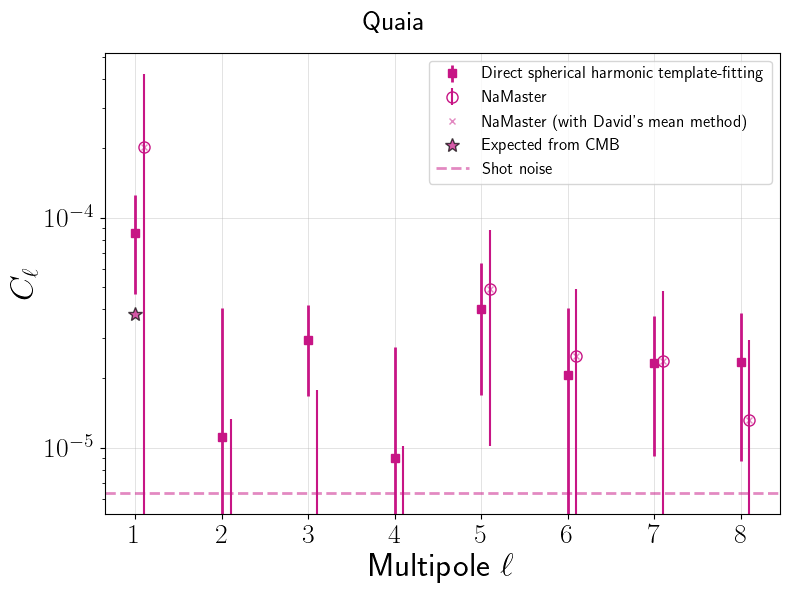

In [90]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
fig.suptitle('Quaia', fontsize=20)

kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)

ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
            c=color_quaia, label=r'Direct spherical harmonic template-fitting', marker='s', **kwargs)

ax.errorbar(leff+0.1, cl[0], yerr=np.sqrt(np.diag(cv)),
            color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
            ls='None', 
            label='NaMaster')

ax.errorbar(leff+0.1, cl_david[0], yerr=None, color=color_quaia, marker='x', alpha=0.5, markersize=4, 
            #markerfacecolor='None',
            ls='None', lw=2, label="NaMaster (with David's mean method)")

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7, ls='None')
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c=color_quaia, label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], c=color_quaia, label='Shot noise', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)

ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')

#ax.legend(loc=1, fontsize=12)
ax.legend(handles=handles, loc=1, fontsize=12)

# Dependence on lmax

In [42]:
l_max_arr = np.arange(1, max_ell+1)
cl_arr_lmaxdep = []
cl_nonl_arr_lmaxdep = []
leff_arr_lmaxdep = []
for l_max in l_max_arr:

    # Bins
    ells_nmt = np.arange(1, l_max+1)
    bpws = np.arange(len(ells_nmt))
    weights = np.ones(len(ells_nmt))/len(ells_nmt)
    b = nmt.NmtBin(d_quaia.NSIDE, ells=ells_nmt, bpws=bpws, weights=weights)
    leff = b.get_effective_ells()
    
    cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, b, pnl=nl_coupled_meanmethodAbby)
    
    cl_nonl, nl_nonl, w_nonl, Bbl_nonl = get_cl(f_quaia, f_quaia, b, pnl=None)
    
    cl_arr_lmaxdep.append(cl)
    cl_nonl_arr_lmaxdep.append(cl_nonl)
    leff_arr_lmaxdep.append(leff)

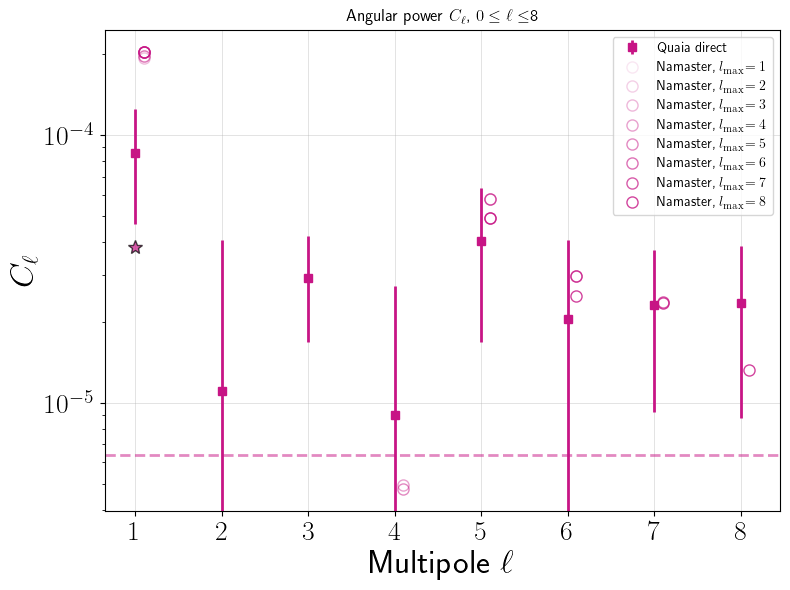

In [91]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
#kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)

ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
                c=color_quaia, label='Quaia direct',
                marker='s', **kwargs)

for i in range(len(l_max_arr)):

    ax.errorbar(leff_arr_lmaxdep[i]+0.1, cl_arr_lmaxdep[i][0], #yerr=np.sqrt(np.diag(cv)),
                color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
                ls='None', 
                label=r'Namaster, $l_\mathrm{{{max}}}$'+rf'$={l_max_arr[i]}$',
                alpha=l_max_arr[i]/10)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
#ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
#ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
#ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
## ax.plot(leff+0.2, cl_ksf[0], color=color_quaia, marker='d_quaia', markersize=8, markerfacecolor='None',
#         ls='None', lw=2, label='NaMaster with Alonso+2023-method delta field, ksf mean')
ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
#ax.legend(loc=1, handles=handles)
ax.legend(loc='upper right', fontsize=10)

Very little dependence on l_max! Only notable one is l=4 which sometimes goes negative and sometimes is just small.

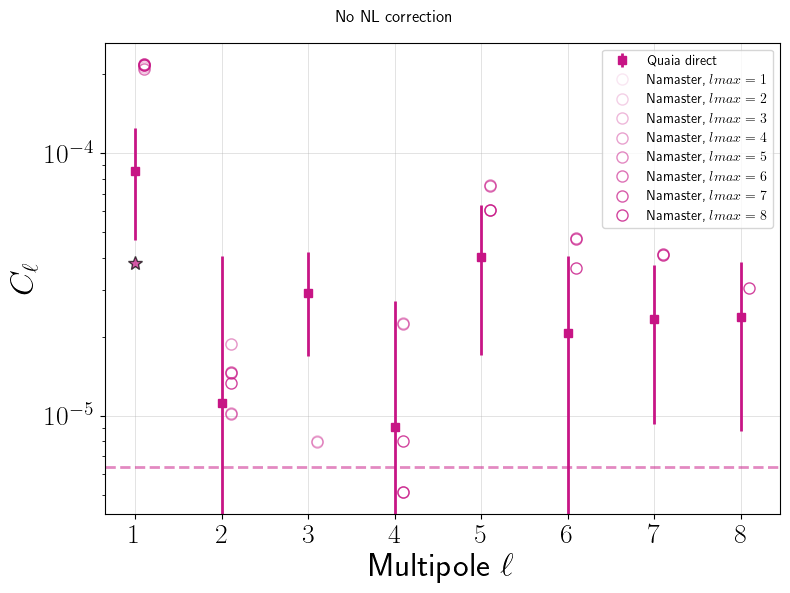

In [92]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
fig.suptitle('No NL correction')
#kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)

ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
                c=color_quaia, label='Quaia direct',
                marker='s', **kwargs)

for i in range(len(l_max_arr)):

    ax.errorbar(leff_arr_lmaxdep[i]+0.1, cl_nonl_arr_lmaxdep[i][0], #yerr=np.sqrt(np.diag(cv)),
                color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
                ls='None', 
                label=rf'Namaster, $lmax={l_max_arr[i]}$',
                alpha=l_max_arr[i]/10)

#     ax.plot(leff+0.2, cl_cat[0], color=color_quaia, marker='+', markersize=12, #markerfacecolor='None',
#             ls='None', lw=2, label='NaMaster with Alonso+2023-method delta field')


# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
#ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
#ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
#ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
#ax.legend(loc=1, handles=handles)
ax.legend(loc='upper right', fontsize=10)

If we don't correct for the NL term, we see more differences, but still not too much (not nearly as much as in direct fitting case) - so the pseudo-Cl part is also doing some of the ell-decoupling

# CatWISE

### C_ells direct

In [116]:
ells, Cells_catwise = multipoles.compute_Cells_in_overdensity_map_Wmask(overdensity_map_sf_catwise,
                                                                      Wmask=Wmask, 
                                                                      max_ell=max_ell, selfunc=selfunc_catwise)

In [117]:
save_dir = '../../quasar_data_abby/jackknife'
Cells_catwise_std = np.load(os.path.join(save_dir, f'jk_Cells_std_catwise_sfcorr_ellmax{max_ell}.npy'),
                            allow_pickle=True).item()['Cells_std']

In [118]:
noise_dir = '../../quasar_data_abby/noise_Cells'
res_catwise = np.load(f'{noise_dir}/catwise_agns/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
noise_catwise_Cell = res_catwise['Cells_fullsky'][0]

In [119]:
expected_C1_catwise = C_1(expected_dipamp_catwise)

### NaMaster

In [130]:
map_catwise = overdensity_map_sf_catwise.copy()
map_catwise[np.isnan(map_catwise)] = 0

To compute nl_coupled, we need the mean, so we need to go back to the number counts datamap::

In [131]:
NPIX = hp.nside2npix(d_catwise.NSIDE)

# mask_sf is the selection function with the binary mask masked out; d.mask is the binary mask
mask_sf_catwise = selfunc_catwise.copy()
mask_sf_catwise[~d_catwise.mask] = 0.0

In [132]:
# Abby computed the overdensity map with the mean like this
nmean_catwise_meanmethodAbby = np.sum(d_catwise.datamap[d_catwise.mask]/(mask_sf_catwise[d_catwise.mask]))/np.sum(d_catwise.mask)
nmean_srad_catwise_meanmethodAbby = nmean_catwise_meanmethodAbby * NPIX / (4*np.pi)
nl_coupled_catwise_meanmethodAbby = np.mean(mask_sf_catwise) / nmean_srad_catwise_meanmethodAbby * np.ones((1, 3*d_catwise.NSIDE))

In [133]:
f_catwise = nmt.NmtField(mask_sf_catwise, [map_catwise], n_iter=0)

In [134]:
cl_catwise, nl_catwise, w_catwise, Bbl_catwise = get_cl(f_catwise, f_catwise, b, 
                        pnl=nl_coupled_catwise_meanmethodAbby)
print(cl_catwise)

[[ 2.06496392e-04  5.94463215e-06  1.83060518e-06  3.71771776e-05
   6.57509174e-06  2.47538865e-06 -3.96194623e-06  7.10530441e-06]]


Covariance computation:

In [135]:
f = f_catwise
cv_catwise = get_cov(f, f, f, f, w, w)

## CatWISE Elatcorr

### C_ells direct

In [126]:
ells, Cells_catwise_elat = multipoles.compute_Cells_in_overdensity_map_Wmask(overdensity_map_elat_catwise,
                                                                      Wmask=Wmask, 
                                                                      max_ell=max_ell, selfunc=None)

In [115]:
save_dir = '../../quasar_data_abby/jackknife'
Cells_catwise_elat_std = np.load(os.path.join(save_dir, f'jk_Cells_std_catwise_elatcorr_ellmax{max_ell}.npy'),
                            allow_pickle=True).item()['Cells_std']

In [64]:
# just have one noise file for catwise, not sure which corr
# noise_dir = '../../quasar_data_abby/noise_Cells'
# res_catwise = np.load(f'{noise_dir}/catwise_agns/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
# noise_catwise_Cell = res_catwise['Cells_fullsky'][0]

In [65]:
# no dep on sf
#expected_C1_catwise_elat = C_1(expected_dipamp_catwise)

### NaMaster

In [129]:
map_catwise_elat = overdensity_map_elat_catwise.copy()
map_catwise_elat[np.isnan(map_catwise_elat)] = 0

To compute nl_coupled, we need the mean, so we need to go back to the number counts datamap::

In [137]:
NPIX = hp.nside2npix(d_catwise.NSIDE)

# mask_sf is the selection function with the binary mask masked out; d.mask is the binary mask
#mask_sf_catwise = selfunc_catwise.copy()
mask_sf_catwise_elat = np.ones(len(map_catwise_elat))
mask_sf_catwise_elat[~d_catwise.mask] = 0.0

In [138]:
# Abby computed the overdensity map with the mean like this
nmean_catwise_elat_meanmethodAbby = np.sum(d_catwise.datamap[d_catwise.mask]/(mask_sf_catwise_elat[d_catwise.mask]))/np.sum(d_catwise.mask)
nmean_srad_catwise_elat_meanmethodAbby = nmean_catwise_meanmethodAbby * NPIX / (4*np.pi)
nl_coupled_catwise_elat_meanmethodAbby = np.mean(mask_sf_catwise) / nmean_srad_catwise_meanmethodAbby * np.ones((1, 3*d_catwise.NSIDE))

In [139]:
f_catwise_elat = nmt.NmtField(mask_sf_catwise_elat, [map_catwise_elat], n_iter=0)

In [140]:
cl_catwise_elat, nl_catwise_elat, w_catwise_elat, Bbl_catwise = get_cl(f_catwise_elat, f_catwise_elat, b, 
                        pnl=nl_coupled_catwise_elat_meanmethodAbby)
print(cl_catwise_elat)

[[ 2.55889291e-04  1.06279617e-05  5.67841071e-08  3.34979449e-05
   6.61170559e-06 -8.74160835e-07  1.71346832e-06  1.24000248e-05]]


Covariance computation:

In [141]:
f = f_catwise_elat
cv_catwise_elat = get_cov(f, f, f, f, w, w)

### CatWISE plots

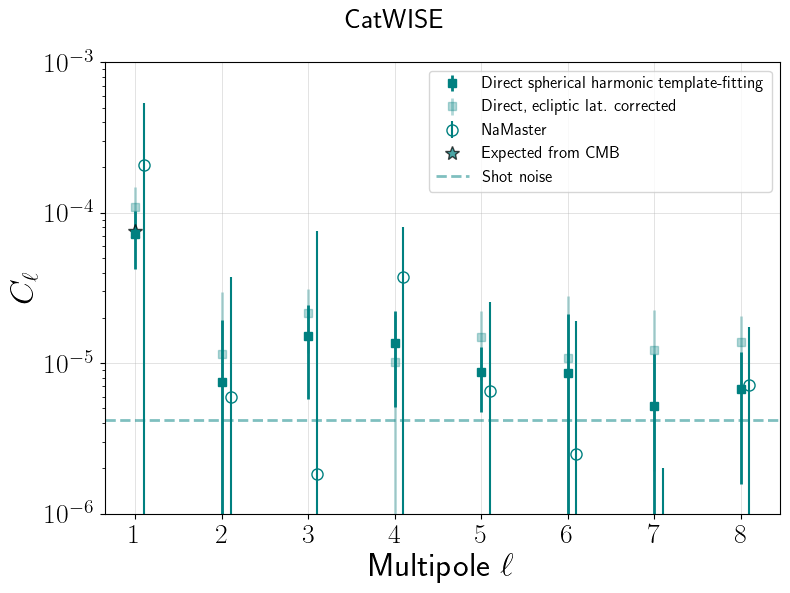

In [149]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
fig.suptitle('CatWISE', fontsize=20)

kwargs = dict(ls='None', ms=6, lw=lw)

ax.errorbar(ells[1:], Cells_catwise[1:], yerr=Cells_catwise_std[1:],
             alpha=1,
            c=color_catwise, label=r'Direct spherical harmonic template-fitting', marker='s', **kwargs)

ax.errorbar(ells[1:], Cells_catwise_elat[1:], yerr=Cells_catwise_elat_std[1:],
            alpha=0.3,
            c=color_catwise, label=r'Direct, ecliptic lat. corrected', marker='s', **kwargs)

ax.errorbar(leff+0.1, cl_catwise[0], yerr=np.sqrt(np.diag(cv_catwise)),
            color=color_catwise, marker='o', markersize=8, markerfacecolor='None',
            ls='None', 
            label='NaMaster')

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7, ls='None')
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c=color_catwise, label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_catwise_Cell, c=color_catwise, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c=color_catwise, **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_catwise_Cell, c=color_catwise, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)

ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_ylim(1e-6, 1e-3)

ax.legend(handles=handles, loc=1, fontsize=12)

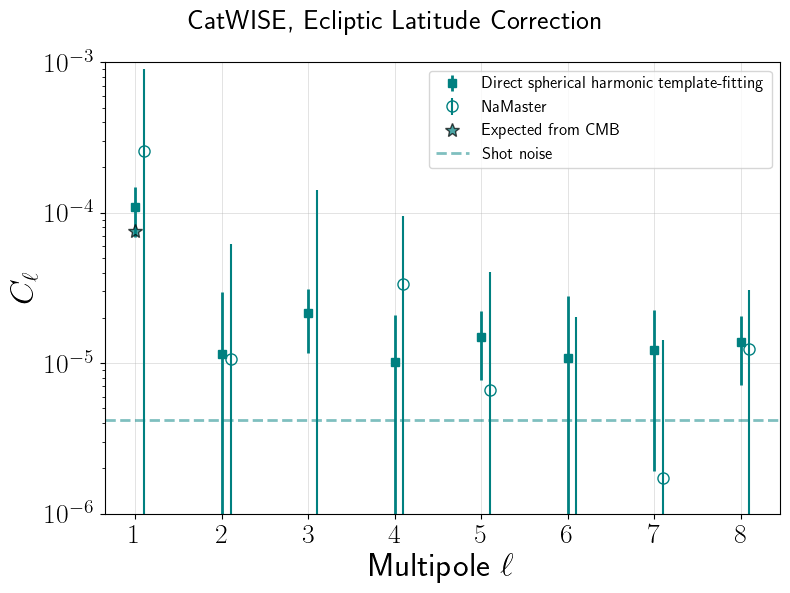

In [145]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
fig.suptitle('CatWISE, Ecliptic Latitude Correction', fontsize=20)

kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)

ax.errorbar(ells[1:], Cells_catwise_elat[1:], yerr=Cells_catwise_elat_std[1:],
            c=color_catwise, label=r'Direct spherical harmonic template-fitting', marker='s', **kwargs)

ax.errorbar(leff+0.1, cl_catwise_elat[0], yerr=np.sqrt(np.diag(cv_catwise_elat)),
            color=color_catwise, marker='o', markersize=8, markerfacecolor='None',
            ls='None', 
            label='NaMaster')

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7, ls='None')
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c=color_catwise, label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_catwise_Cell, c=color_catwise, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c=color_catwise, **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_catwise_Cell, c=color_catwise, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)

ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_ylim(1e-6, 1e-3)

ax.legend(handles=handles, loc=1, fontsize=12)